In [1]:
import glob
import numpy as np
import cv2
from PIL import Image
from sklearn import datasets, linear_model
import matplotlib.pyplot as plt

# Read the calibration images from folder CalibImages
filelist = glob.glob("./CalibImages/*.JPG")
filelist

['./CalibImages/8.JPG',
 './CalibImages/9.JPG',
 './CalibImages/12.JPG',
 './CalibImages/13.JPG',
 './CalibImages/11.JPG',
 './CalibImages/10.JPG',
 './CalibImages/4.JPG',
 './CalibImages/5.JPG',
 './CalibImages/7.JPG',
 './CalibImages/6.JPG',
 './CalibImages/2.JPG',
 './CalibImages/3.JPG',
 './CalibImages/1.JPG',
 './CalibImages/0.JPG']

### Create a 100x100 window in the center of the image for sampling

In [2]:
width = np.shape(cv2.imread(filelist[0]))[0]
length = np.shape(cv2.imread(filelist[0]))[1]

s_wi_start = int((width - 100)/2)
s_len_start = int((length - 100)/2)

### Shutter speed extracted from the images' EXIF, stored in speed_arr

In [3]:
def shutter_speed(filelist):
    speed_arr = []
    for file in filelist:### Create a 100x100 window in the center of the image for sampling
        exif_data = Image.open(file)._getexif()
        speed = float(10/exif_data[33434][1])
        speed_arr.append(speed)
    return speed_arr
speed_arr = shutter_speed(filelist)
log_speed = np.log(speed_arr)

### Read the 14 calibration images, store all red, green, blue values separate channels (red_arr, green_arr, blue_arr each has size 100x100x14) 

In [4]:
def channels(filelist):
    count = 0
#     red_arr = []
#     green_arr = []
#     blue_arr = []
    for file in filelist:
        img = cv2.imread(file)

        if count == 0:
            red_arr = img[s_wi_start:s_wi_start + 100, s_len_start:s_len_start + 100, 0]
            green_arr = img[s_wi_start:s_wi_start + 100, s_len_start:s_len_start + 100, 1]
            blue_arr = img[s_wi_start:s_wi_start + 100, s_len_start:s_len_start + 100, 2]
        else: 
            red = img[s_wi_start:s_wi_start + 100, s_len_start:s_len_start + 100, 0]
            green = img[s_wi_start:s_wi_start + 100, s_len_start:s_len_start + 100, 1]
            blue = img[s_wi_start:s_wi_start + 100, s_len_start:s_len_start + 100, 2]

            red_arr = np.dstack((red_arr, red))
            green_arr = np.dstack((green_arr, green))
            blue_arr = np.dstack((blue_arr, blue))
        count += 1
    return red_arr, green_arr, blue_arr
red_arr, green_arr, blue_arr = channels(filelist)
# plt.imshow(img_crop)
# plt.show()

### Take the log of the mean of the red, green, blue_arr obtained above

In [5]:
red_mean = np.mean(red_arr, axis = (0,1))
green_mean = np.mean(green_arr, axis = (0,1))
blue_mean = np.mean(blue_arr, axis = (0,1))

log_red = np.log(red_mean)
log_green = np.log(green_mean)
log_blue = np.log(blue_mean)

### "Straightening" the B-T correlation to linear using linear regression: 
### $log(B') = b + a\cdot log(T)$ where $B = B'^g$ and $g = 1/a$
### then plot the following graphs: ($B'$, $T$), ($log(B')$, $log(T)$) and ($B = B'^g, T$)

In [6]:
regr = linear_model.LinearRegression()

def training(speed_arr, log_speed, mean, log_mean):

    x = np.array(log_speed).reshape(len(log_speed),1)
    y = np.array(log_mean).reshape(len(log_mean),1)
    regr.fit(x, y)
    a = regr.coef_[0][0]
    b = regr.intercept_[0]
    g = 1/a
    print('a =', a)
    print('g =', g)
    print('b =', b)
    y_predict = regr.predict(x)
    
    plt.figure(figsize=(18,4))
    plt.subplot(1,3,1)
    plt.scatter(speed_arr, mean, color ='Red')
    plt.xlabel('T')
    plt.ylabel('B\'')
    
    plt.subplot(1,3,2)
    plt.scatter(x,y,color ='Red')
    plt.plot(x,y_predict)
    plt.plot()
    plt.xlabel('log(T)')
    plt.ylabel('log(B\')')

    plt.subplot(1,3,3)
    plt.scatter(speed_arr,np.power(mean,g),color ='Red')
    plt.xlabel('T')
    plt.ylabel('B\'^g')
    plt.show()

### Estimate $a$, $g = 1/a$ and $b$ 
### Plot ($B'$, $T$), ($log(B')$, $log(T)$) and ($B = B'^g, T$) graphs for the red channel:

a = 0.557020112103
g = 1.79526731311
b = 7.50635225514


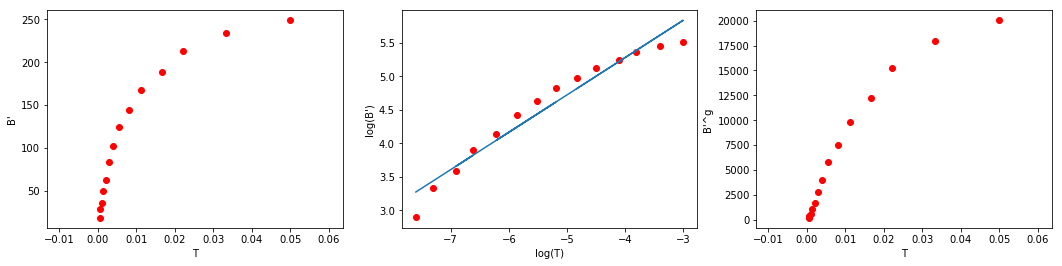

In [7]:
training(speed_arr, log_speed, red_mean, log_red)

### Estimate $a$, $g = 1/a$ and $b$ 
### Plot ($B'$, $T$), ($log(B')$, $log(T)$) and ($B = B'^g, T$) graphs for the green channel:

a = 0.53851727568
g = 1.85695064051
b = 7.42782628693


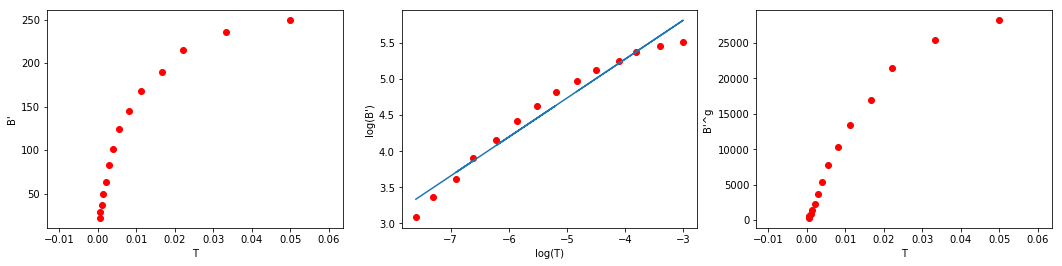

In [8]:
training(speed_arr, log_speed, green_mean, log_green)

### Estimate $a$, $g = 1/a$ and $b$ 
### Plot ($B'$, $T$), ($log(B')$, $log(T)$) and ($B = B'^g, T$) graphs for the blue channel:

a = 0.589123283607
g = 1.69743757856
b = 7.56462371849


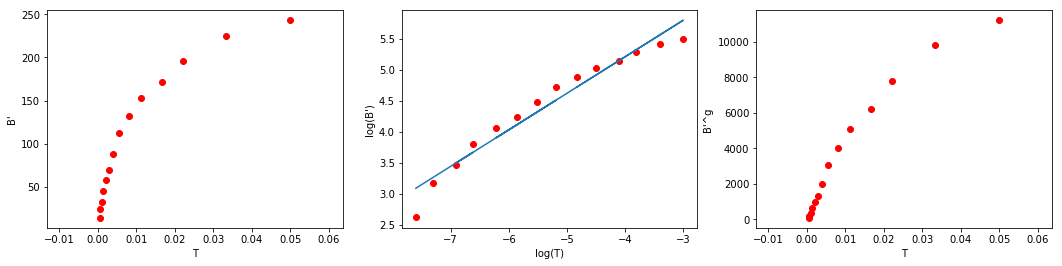

In [9]:
training(speed_arr, log_speed, blue_mean, log_blue)